In [19]:
import pandas as pd
import json
import numpy as np
from surprise import Reader, Dataset, SVD, accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 75,
    })

## all models predictions to same structure

In [20]:
with open("data/models.json", "r") as file:
    dicio_loaded = json.load(file)

X1 = np.array(dicio_loaded["model01"]["x"])
Theta1 = np.array(dicio_loaded["model01"]["theta"])

X2 = np.array(dicio_loaded["model02"]["x"])
Theta2 = np.array(dicio_loaded["model02"]["theta"])

p1 = X1 @ Theta1.T
p2 = X2 @ Theta2.T


ratings = pd.read_csv("data/model03_predictions.csv")
ratings.rename(columns={'predicted_rating': 'pred_model03'}, inplace=True)

In [21]:
with open("data/data_ids.json", "r") as file:
    ids = json.load(file)

ratings1 = []
ratings2 = []
for index, row in ratings.iterrows():
    mrow = ids["moviesIDs"][str(int(row["movieId"]))]
    mcolumn = ids["userIDs"][str(int(row["userId"]))]

    ratings1.append(p1[mrow, mcolumn])
    ratings2.append(p2[mrow, mcolumn])
    
ratings["pred_model01"] = ratings1
ratings["pred_model02"] = ratings2

ratings

,userId,movieId,true_rating,pred_model03,pred_model01,pred_model02
0,509,7347,3.0,3.163964,2.634479,3.365576
1,509,4993,5.0,3.800083,4.264976,3.536390
2,509,2028,3.5,3.702885,3.316138,3.131115
3,509,85510,3.5,3.106511,2.883959,3.204191
4,509,94780,2.5,2.721008,2.204579,3.193802
...,...,...,...,...,...,...
100831,375,2431,4.5,3.835049,3.003787,4.467561
100832,375,1438,2.0,3.229131,2.800299,3.400763
100833,375,2805,4.0,3.377512,2.457078,3.824780
100834,375,2046,4.0,3.599648,2.795816,2.928077


## split to train and test as it was

In [22]:
df_train = pd.read_csv("data/data_train.csv")[["userId", "movieId"]]
df_test = pd.read_csv("data/data_test.csv")[["userId", "movieId"]]

df_train = df_train.merge(ratings, on=["userId", "movieId"])
df_test = df_test.merge(ratings, on=["userId", "movieId"])

---
---
---

## boxplot of rmse and mae with 8cv across all data

In [23]:
import ourfunctions as of

In [24]:
"""df_shuffled = ratings.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

data_boxplot = {}
for exclude_index in range(8):
    print(f"Fold {exclude_index}: ", end="")
    fit_data = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

    Y, R = of.utility_matrix_AND_binary_matrix(fit_data)
    Y, R = Y.toarray(), R.toarray()

    num_movies, num_users = Y.shape
    num_features = 20

    # model 01
    X01 = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
    Theta01 = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = np.append(X01.flatten(),Theta01.flatten())
    param, jhist = of.gradientDescent(params,Y,R,num_users,num_movies,num_features,
                                   dicio_loaded["model01"]["alpha"], 750, dicio_loaded["model01"]["lambda"])
    X01 = param[:num_movies*num_features].reshape(num_movies,num_features)
    Theta01 = param[num_movies*num_features:].reshape(num_users,num_features)
    p = X01 @ Theta01.T
    p = p.clip(min=0, max=5)
    RMSE = 0
    MAE = 0
    for i, row in folds[exclude_index].iterrows():
        movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
        userId_matrix = ids["userIDs"][str(int(row["userId"]))]
        RMSE += abs(row["true_rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        MAE += abs(row["true_rating"] - p[int(movieId_matrix), int(userId_matrix)])
    MAE = MAE/len(folds[exclude_index])
    RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
    data_boxplot[("model01", "rmse", exclude_index)] = RMSE
    data_boxplot[("model01", "mae", exclude_index)] = MAE
    print("model 01 done", end="; ")

    # model 02
    X02 = np.array(dicio_loaded["model02"]["x"])
    Theta02 = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = Theta02
    param, jhist = of.gradientDescent_Xknown(params,X02,Y,R,num_users,num_movies,num_features,
                                             dicio_loaded["model02"]["alpha"], 750, dicio_loaded["model02"]["lambda"])
    Theta02 = param
    p = X02 @ Theta02.T
    p = p.clip(min=0, max=5)
    RMSE = 0
    MAE = 0
    for i, row in folds[exclude_index].iterrows():
        movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
        userId_matrix = ids["userIDs"][str(int(row["userId"]))]
        RMSE += abs(row["true_rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        MAE += abs(row["true_rating"] - p[int(movieId_matrix), int(userId_matrix)])

        #print(row["true_rating"],  p[int(movieId_matrix), int(userId_matrix)], MAE)

    MAE = MAE/len(folds[exclude_index])
    RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
    data_boxplot[("model02", "rmse", exclude_index)] = RMSE
    data_boxplot[("model02", "mae", exclude_index)] = MAE
    print("model 02 done", end="; ")

    # model 03
    reader = Reader(rating_scale=(1, 5))
    traindata = Dataset.load_from_df(fit_data[['userId', 'movieId', 'true_rating']], reader)
    trainset = traindata.build_full_trainset()
    test_reader = Reader(rating_scale=(1, 5))
    test_data = Dataset.load_from_df(df_test[['userId', 'movieId', 'true_rating']], test_reader)
    testset = test_data.build_full_trainset().build_testset()
    model03 = SVD(n_factors=50, 
                lr_all=0.01, 
                reg_all=0.1)
    model03.fit(trainset)
    predictions_test = model03.test(testset)
    data_boxplot[("model03", "rmse", exclude_index)] = accuracy.rmse(predictions_test, verbose=False)
    data_boxplot[("model03", "mae", exclude_index)] = accuracy.mae(predictions_test, verbose=False)
    print("model 03 done.")"""
"" # results sored in data_boxplot_stored

''

In [25]:
data_boxplot_stored = {('model01', 'rmse', 0): 1.2102220824280587,
 ('model01', 'mae', 0): 0.8802126157611764,
 ('model02', 'rmse', 0): 1.188519389631588,
 ('model02', 'mae', 0): 0.8551858067978659,
 ('model03', 'rmse', 0): 0.7713445009719978,
 ('model03', 'mae', 0): 0.595582159382301,
 ('model01', 'rmse', 1): 1.2017004328254788,
 ('model01', 'mae', 1): 0.876751036592757,
 ('model02', 'rmse', 1): 1.1890489418094852,
 ('model02', 'mae', 1): 0.8555244286978224,
 ('model03', 'rmse', 1): 0.772114879310227,
 ('model03', 'mae', 1): 0.5961263991484963,
 ('model01', 'rmse', 2): 1.1940345435150537,
 ('model01', 'mae', 2): 0.8679178413665524,
 ('model02', 'rmse', 2): 1.2200229898424457,
 ('model02', 'mae', 2): 0.8686388634257602,
 ('model03', 'rmse', 2): 0.7694914596410893,
 ('model03', 'mae', 2): 0.5935519691228067,
 ('model01', 'rmse', 3): 1.2055288673447837,
 ('model01', 'mae', 3): 0.8814913064318333,
 ('model02', 'rmse', 3): 1.2206809121858435,
 ('model02', 'mae', 3): 0.8678290630645263,
 ('model03', 'rmse', 3): 0.773817179754284,
 ('model03', 'mae', 3): 0.5968397669623388,
 ('model01', 'rmse', 4): 1.1838786041852756,
 ('model01', 'mae', 4): 0.8614144559564502,
 ('model02', 'rmse', 4): 1.2039567755043965,
 ('model02', 'mae', 4): 0.8607496418608352,
 ('model03', 'rmse', 4): 0.7733924422884445,
 ('model03', 'mae', 4): 0.5956943164305888,
 ('model01', 'rmse', 5): 1.1875857303248674,
 ('model01', 'mae', 5): 0.8663362003677715,
 ('model02', 'rmse', 5): 1.2312620814120254,
 ('model02', 'mae', 5): 0.8810374889167211,
 ('model03', 'rmse', 5): 0.7738368358308663,
 ('model03', 'mae', 5): 0.5970085172127266,
 ('model01', 'rmse', 6): 1.2106758337676455,
 ('model01', 'mae', 6): 0.8785346211382264,
 ('model02', 'rmse', 6): 1.2305270842619633,
 ('model02', 'mae', 6): 0.877668214888896,
 ('model03', 'rmse', 6): 0.7764918667461985,
 ('model03', 'mae', 6): 0.5979497993096581,
 ('model01', 'rmse', 7): 1.1839785653451136,
 ('model01', 'mae', 7): 0.8653780579235952,
 ('model02', 'rmse', 7): 1.2209134870233311,
 ('model02', 'mae', 7): 0.8693446276935669,
 ('model03', 'rmse', 7): 0.7746672833620631,
 ('model03', 'mae', 7): 0.5968611529409624}

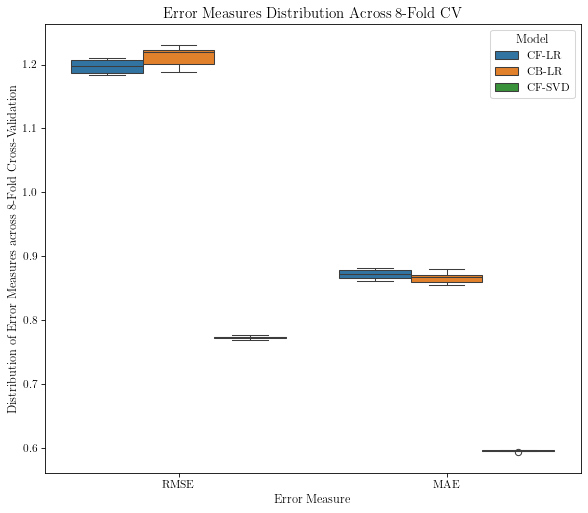

In [ ]:
records = [{'model': k[0], 'error_measure': k[1], 'fold': k[2], 'value': v} for k, v in data_boxplot_stored.items()]
df = pd.DataFrame(records)

df["error_measure"] = df["error_measure"].map({"rmse": "RMSE", "mae": "MAE"})
df["model"] = df["model"].map({"model01": "CF-LR", "model02": "CB-LR", "model03": "CF-SVD"})

plt.figure(figsize=(8, 7))
sns.boxplot(data=df, x='error_measure', y='value', hue='model')
plt.xlabel("Error Measure")
plt.ylabel("Distribution of Error Measures across 8-Fold Cross-Validation")
plt.legend(title="Model")
plt.title("Error Measures Distribution Across 8-Fold CV")
plt.tight_layout()
#plt.savefig("assets/results_boxplot.png")
plt.show()

---
---
---

In [33]:
df_test

,userId,movieId,true_rating,pred_model03,pred_model01,pred_model02
0,432,77866,4.5,3.193379,2.350174,3.778596
1,288,474,3.0,3.298265,3.205631,2.807328
2,599,4351,3.0,2.671774,3.031805,2.736422
3,42,2987,4.0,3.805529,3.900734,3.542831
4,75,1610,4.0,3.447783,3.454064,3.535868
...,...,...,...,...,...,...
20163,380,5048,2.0,3.594276,3.177091,3.420218
20164,434,54272,3.5,3.459016,2.980255,4.739432
20165,226,5989,4.5,3.857971,4.284924,3.795565
20166,607,1320,3.0,3.449466,3.899191,3.446254


In [34]:
df_train

,userId,movieId,true_rating,pred_model03,pred_model01,pred_model02
0,509,7347,3.0,3.163964,2.634479,3.365576
1,326,71462,4.0,4.133532,3.914982,4.485783
2,57,2115,3.0,3.497102,3.450018,3.399617
3,610,1127,4.0,3.683115,4.335210,3.612603
4,462,2409,2.0,2.964133,2.820060,3.110287
...,...,...,...,...,...,...
80663,42,4005,4.0,3.849544,3.541342,3.309666
80664,364,141,4.0,3.936729,3.655626,4.224037
80665,480,6867,4.0,3.464010,3.831875,3.418197
80666,6,981,3.0,3.463961,2.637851,3.634696
